# Home Assignment No. 1: Part 1 (Practice)
To solve this task, you will write a lot of code to try several machine learning methods for classification and regression.
* You are **HIGHLY RECOMMENDED** to read relevant documentation, e.g. for [python](https://docs.python.org/3/), [numpy](https://docs.scipy.org/doc/numpy/reference/), [matlpotlib](https://matplotlib.org/) and [sklearn](https://scikit-learn.org/stable/). Also remember that seminars, lecture slides, [Google](http://google.com) and [StackOverflow](https://stackoverflow.com/) are your close friends during this course (and, probably, whole life?).

* If you want an easy life, you have to use **BUILT-IN METHODS** of `sklearn` library instead of writing tons of your own code. There exists a class/method for almost everything you can imagine (related to this homework).

* To do this part of homework, you have to write **CODE** directly inside specified places inside notebook **CELLS**.

* In some problems you are asked to provide short discussion of the results. In these cases you have to create **MARKDOWN** cell with your comments right after the corresponding code cell.

* For every separate problem you can get only 0 points or maximal points for this problem. There are **NO INTERMEDIATE scores**. So make sure that you did everything required in the task

* Your **SOLUTION** notebook **MUST BE REPRODUCIBLE**, i.e. if the reviewer decides to execute all, after all the computation he will obtain exactly the same solution (with all the corresponding plots) as in your uploaded notebook. For this purpose, we suggest to fix random `seed` or (better) define `random_state=` inside every algorithm that uses some pseudorandomness.

* Your code must be clear to the reviewer. For this purpose, try to include neccessary comments inside the code. But remember: **GOOD CODE MUST BE SELF-EXPLANATORY** without any additional comments.

* Many `sklearn` algorithms support multithreading (Ensemble Methods, Cross-Validation, etc.). Check if the particular algorithm has `n_jobs` parameters and set it to `-1` to use all the cores.

To begin with, let's import the essential (for this assignment) libraries.

In [1]:
#!pip install mlxtend

In [1]:
import numpy as np

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

import pandas as pd

from sklearn.datasets import make_moons, make_circles

from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from mlxtend.plotting import plot_decision_regions
import matplotlib.gridspec as gridspec
import itertools
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.random_projection import GaussianRandomProjection

## Task 1. Matplotlib (2 points)

Plot the level sets of the $l^p$ norm (actually, this is not a norm for $p<1$)
\begin{equation}
    \|z\|_p = \biggl(\sum_i \lvert x_i\rvert^p\biggr)^\tfrac1{p}
        \,,
\end{equation}
and make the contour of the unit ball in $l^p$ norm stand out. Draw plots
for $p \in \{0, \tfrac1{25}, \tfrac12, 1, 1.5, 2, 7, \infty\}$.

Study plotting examples on [this](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.contourf.html#matplotlib.pyplot.contourf) and [this](http://scikit-learn.org/stable/auto_examples/svm/plot_oneclass.html) pages (**especially the last one**) and have a look at these functions: *np.meshgrid*, *np.linspace* in numpy's documentation. We suggest to use `np.linalg.norm`.

Try to produce a plot that **looks like the one below**:

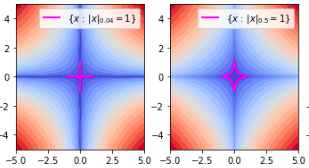

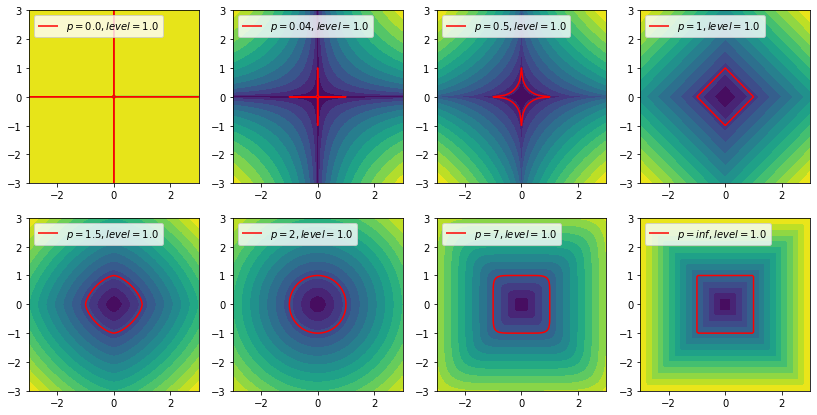

In [2]:
p_values = [0., 0.04, 0.5, 1, 1.5, 2, 7, np.inf]
x = np.linspace(-3, 3, num=101)
y = np.linspace(-3, 3, num=101)
xx, yy = np.meshgrid(x,y)

fig, axes = plt.subplots(ncols=(len(p_values) + 1)// 2,
                         nrows=2, figsize=(14, 7))

for p, ax in zip(p_values, axes.flat):
    zz = np.linalg.norm(np.stack((xx, yy)), ord=p, axis=0)
    h = ax.contourf(x, y, zz, levels=15)
    
    CS = ax.contour(x, y, zz, levels = [1], colors = ['r'])
    text = f'p = {p}, level'
    h1,l1 = CS.legend_elements(text)

    ax.legend(h1,l1,loc='upper left')

plt.show()

## Task 2. Decision Rules and Feature Engeneering (1+1=2 points)

In this task, your goal is to visualize the decision rules of several classifiers applied to artificial $2$-dimensional dataset generated by builtin `sklearn.datasets` method called `make_moons`. In the cell below we generate the dataset.

In [3]:
def make_sunny_moons(n_sun=50, n_moons=100, noise=0.0, sun_radius=1.9, theta=None):
    X_moons, y_moons = make_moons(n_samples=n_moons, noise=noise, random_state=0)
    if not n_sun:
        return X_moons, y_moons
    
    np.random.seed(0xBEEFBAD)
    angles = np.arange(0, 2 * np.pi, 2 * np.pi / n_sun)
    X_sun = sun_radius * np.column_stack([np.cos(angles), np.sin(angles)]) + np.array([0.5, 0.25])
    X_sun += np.random.normal(scale=noise, size=X_sun.shape)
    y_sun = 2 * np.ones(n_sun)
    
    X = np.vstack([X_moons, X_sun])
    y = np.concatenate([y_moons, y_sun]).astype(int)
    X -= X.mean(axis=0)
    
    if theta is None:
        theta = np.pi / 4
    c, s = np.cos(theta), np.sin(theta)
    R = np.array(((c,-s), (s, c)))
    X = X @ R
    
    return X, y

X, y = make_sunny_moons(n_sun=150, n_moons=300, noise=0.15)

### Subproblem 2.1. Decision Rule Plotting (1 of 2 points)

The goal of the subproblem is to fit the following classifiers on features `X` to target `y`:
* Decision Tree (single!) with small depth ($\leq 4$);
* Random Forest with small number of trees ($\leq 25$) of small depth ($\leq 4$);
* Logistic Regreesion;
* Support Vector Machine with RBF kernel;
* Gaussian Naive Bayes;
* k-Nearest Neighbor Classifier with small number of neighbors (e.g. $3$);

For all the fitted classifiers you have to plot the decision regions (the example is shown below the cell). Each plot must have **Title** which contains name of the classifier and its accuracy (only **two** decimal places) on the data.

You can write the plotting code on your own, but we highly recommend just to use `mlxtend` library (`pip install mlxtend` in linux terminal), which has awesome one-line decision rule plotting function (you are to [google](http://google.com) it).

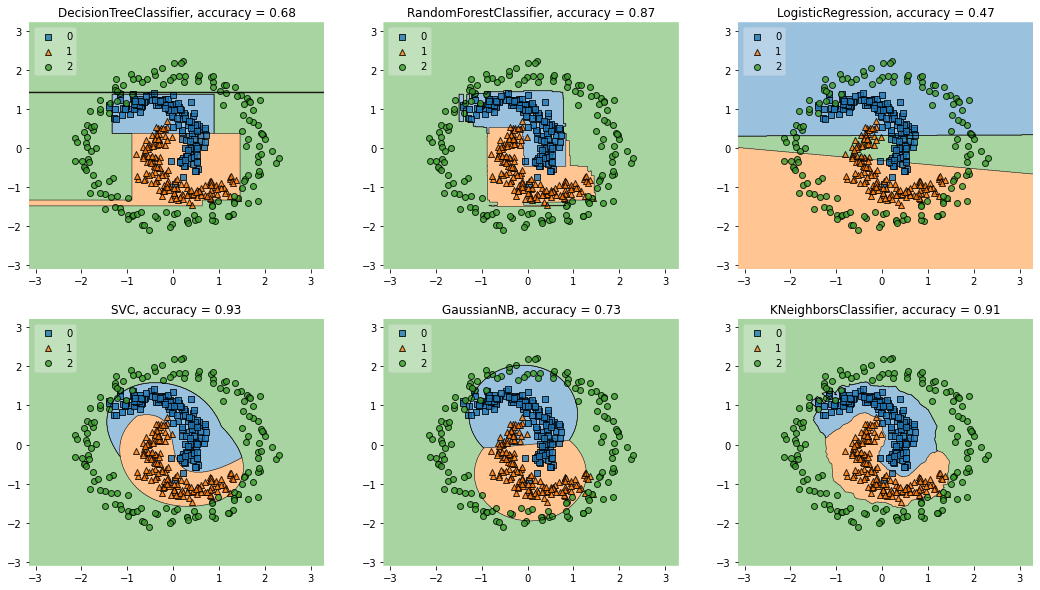

In [4]:
dtc = DecisionTreeClassifier(max_depth=4, random_state=0)
rfc = RandomForestClassifier(n_estimators=20, max_depth=4, n_jobs=-1, random_state=0)
lr = LogisticRegression(n_jobs=-1, random_state=0)
svc = SVC(kernel='rbf', random_state=0)
gnb = GaussianNB()
knc = KNeighborsClassifier(n_neighbors=3, n_jobs=-1)

algs = [dtc, rfc, lr, svc, gnb, knc]

gs = gridspec.GridSpec(2, 3)
fig = plt.figure(figsize=(18, 10))

labels = ['DecisionTreeClassifier',
          'RandomForestClassifier',
          'LogisticRegression',
          'SVC',
          'GaussianNB',
          'KNeighborsClassifier']

for clf, lab, grd in zip(algs,
                         labels,
                         itertools.product([0, 1],[0, 1, 2])):
    clf.fit(X, y)
    acc = cross_val_score(clf,X,y,n_jobs=-1,cv=10).mean()
    ax = plt.subplot(gs[grd[0], grd[1]])
    fig = plot_decision_regions(X, y, clf, legend=2)
    plt.title(lab+', accuracy = {:.2f}'.format(acc))

plt.show()

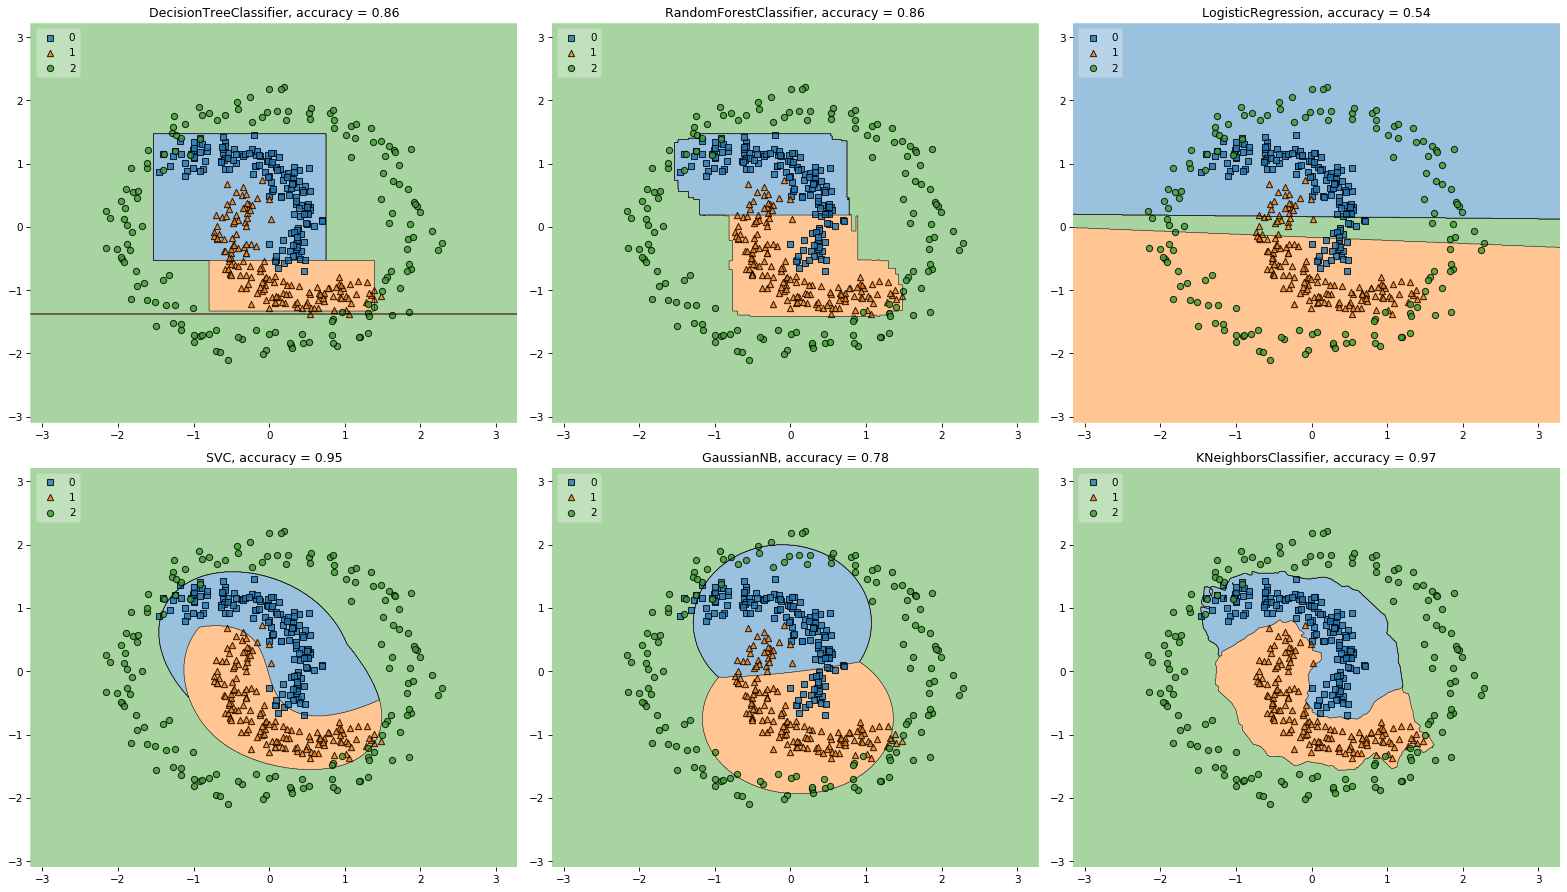

In [8]:
#This is an example plot, don't run it

### Subproblem 2.2. Pipeline: Fitting to Data by Feature Engeneering (1 of 2 points)
In previous task 4.1 several classifiers obviously failed fitting to data. This happend because the decision rule of the classifier has a restricted form (e.g. linear for linear models), while the data is more complicated.

One may try to change the parameters of the classifier (e.g. increase the number of trees in Forest) in order to improve accuracy, but some models (especially linear) do not have parameters that can change the form of the decision rule.

In this case the **feature engeneering** helps: one may try to compute new (e.g. non-linear) features based on the existing pool and fit the classifier in the new features. This may help low-complex classifiers to fit to hard data dependencies.

Your task it to
* Choose **two classifiers** from the previous problem among Decision Tree, Random Forest, Naive Bayes, Logistic Regression;
* By generating of additional features (e.g. polynomial) make them achieve accuracy $>0.95$.
* For each classifier, write 2-3 sentences why did you choose these features.
* Plot their decision rules in the original feature space.

It is your choice how to generate features. You may create hand-crafted featues and add them manually. Nevertheless, we **highly suggest** to get used to and apply the following builtin `sklearn` methods:
* `PolynomialFeatures`, `GaussianRandomProjection` among others - for feature generation
* `StandartScaler`, `MinMaxScaler` among others - for feature scaling
* `Pipeline` - for combining several operations in a row (e.g. feature creation & prediction)

In [5]:
class add_features_1(object):

    def fit(self, X, y=None):
        return self

    def transform(self, X,  y=None):
        X_new = X.copy()
        X_new = np.hstack((X_new, (X[:,0].reshape((-1,1)))**2 + (X[:,1].reshape((-1,1)))**2))
        X_new = np.hstack((X_new, (X[:,0].reshape((-1,1))+0.3)**2 + (X[:,1].reshape((-1,1))-0.3)**2))
        X_new = np.hstack((X_new, (X[:,0].reshape((-1,1))-0.8)**2 + (X[:,1].reshape((-1,1))+0.00)**2))
        X_new = np.hstack((X_new, X[:,1].reshape((-1,1)) - (X[:,0].reshape((-1,1)))**3 - X[:,0].reshape((-1,1))))
        X_new = np.hstack((X_new, 1.0/X[:,0].reshape((-1,1))))
        X_new = np.hstack((X_new, 1.0/X[:,1].reshape((-1,1))))
        
        return X_new

In [6]:
class add_features_2(object):
    
    def fit(self, X, y=None):
        return self

    def transform(self, X,  y=None):
        X_new = X.copy()
        X_new = np.hstack((X_new, (X[:,0].reshape((-1,1)))**2 + (X[:,1].reshape((-1,1)))**2))
        X_new = np.hstack((X_new, (X[:,0].reshape((-1,1))+0.3)**2 + (X[:,1].reshape((-1,1))-0.3)**2))
        X_new = np.hstack((X_new, (X[:,0].reshape((-1,1))-0.8)**2 + (X[:,1].reshape((-1,1)))**2))
        X_new = np.hstack((X_new, X[:,1].reshape((-1,1)) - (X[:,0].reshape((-1,1)))**3 - (X[:,0].reshape((-1,1)))))
        X_new = np.hstack((X_new, 1.0/X[:,0].reshape((-1,1))))
        X_new = np.hstack((X_new, 1.0/X[:,1].reshape((-1,1))))
        
        return X_new

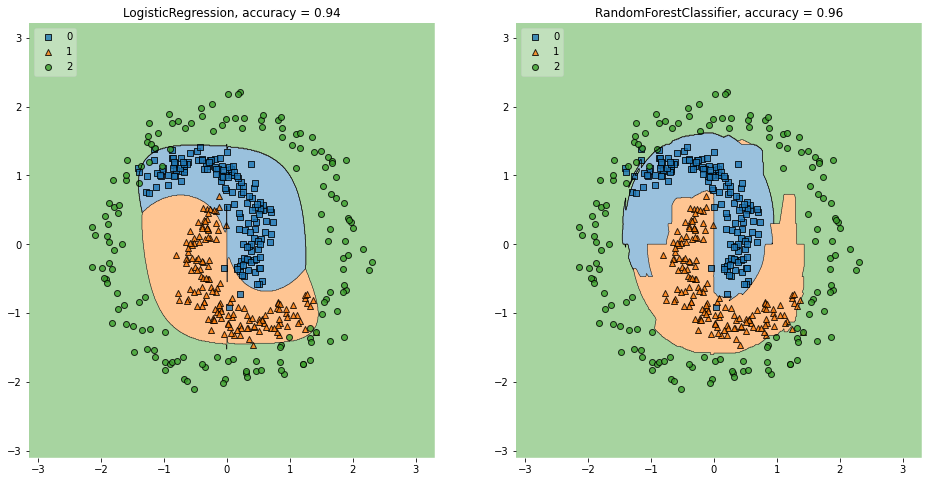

In [7]:
labels = ['DecisionTreeClassifier',
          'RandomForestClassifier',
          'LogisticRegression',
          'SVC',
          'GaussianNB',
          'KNeighborsClassifier']

gs = gridspec.GridSpec(1, 2)
fig = plt.figure(figsize=(16, 8))

pipe_1 = Pipeline([('poly', PolynomialFeatures(4)), 
                   ('add_feature', add_features_1()),
                   ('clf', lr)])
pipe_1.fit(X, y)
acc_1 = cross_val_score(pipe_1, X, y, n_jobs=-1, cv=10).mean()
ax = plt.subplot(gs[0, 0])
fig = plot_decision_regions(X, y, pipe_1, legend=2)
plt.title(labels[2]+', accuracy = {:.2f}'.format(acc_1))


pipe_2 = Pipeline([('scaler', StandardScaler()), 
                   ('add_feature', add_features_2()),
                   ('clf', rfc)])
pipe_2.fit(X, y)
acc_2 = cross_val_score(pipe_2, X, y, n_jobs=-1, cv=10).mean()
ax = plt.subplot(gs[0, 1])
fig = plot_decision_regions(X, y, pipe_2, legend=2)
plt.title(labels[1]+', accuracy = {:.2f}'.format(acc_2))


plt.show()

Для задачи классификации в линейной регрессии невозможно произвести линейное разделение точек, поэтому добавляем полиномиальные признаки. Граница становится нелинейной и точность предсказаний увеличивается. Порядок, равный 4, дает наибольшую точность. Также точность для обоих моделей увеличивают добавленные фичи, подобранные так, чтобы они разделяли данные. В моем случае - это окружности, гиперболы и кубическая функция.

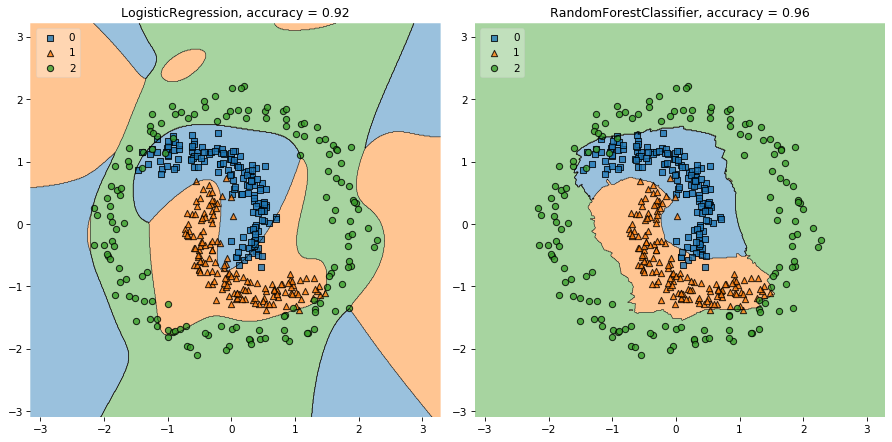

In [10]:
### BEGIN Solution

### END Solution

# Home Assignment No. 1: Part 2 (Theory)

In this part of the homework you are to solve several simple theoretical problems related to machine learning algorithms.
* For every separate problem you can get only 0 points or maximal points for this problem. There are **NO INTERMEDIATE scores**.
* Your solution must me **COMPLETE**, i.e. contain all required formulas/proofs/detailed explanations.
* You must write your solution for any problem right after the words **YOUR SOLUTION**. Attaching pictures of your handwriting is allowed, but **highly discouraged**.
## $\LaTeX$ in Jupyter
Jupyter has constantly improving $\LaTeX$ support. Below are the basic methods to
write **neat, tidy, and well typeset** equations in your notebooks:
* to write an **inline** equation use 
```markdown
$ you latex equation here $
```
* to write an equation, that is **displayed on a separate line** use 
```markdown
$$ you latex equation here $$
```
* to write a **block of equations** use 
```markdown
\begin{align}
    left-hand-side
        &= right-hand-side on line 1
        \\
        &= right-hand-side on line 2
        \\
        &= right-hand-side on the last line
\end{align}
```
The **ampersand** (`&`) aligns the equations horizontally and the **double backslash**
(`\\`) creates a new line.

## Task 1. Linear Regression (1 point)
Let us consider the problem of linear regression for 2D data $(x_{1},y_{1}),\dots,(x_{n},y_{n})\in\mathbb{R}^{2+ 1}$. Let us have $l_{\infty}$ regularization penalty, i.e. the optimization problem is
$$
||Xw - y||_2^2 + \lambda||w||_{\infty} \rightarrow \min_{\boldsymbol{w}}
$$

Show that this problem is equal to Lasso regression problem with feature matrix $Z = XA \in \mathbb{R}^{n \times 2}$ for a certain $2 \times 2$ matrix $A$ and the same target $y$.
### Your solution:

Нужно показать, что
$$
||Xw - y||_2^2 + \lambda||w||_{\infty} \rightarrow \min_{\boldsymbol{w}} \Leftrightarrow ||XAw - y||_2^2 + \lambda||w||_{1} \rightarrow \min_{\boldsymbol{w}}.
$$

Пусть $\tilde{w} = Aw,$ тогда задача минимизации справа эквивалентна следующей (при условии невырожденности матрицы A):
$$
||X\tilde{w} - y||_2^2 + \lambda||A^{-1} \tilde{w}||_{1} \rightarrow \min_{\boldsymbol{\tilde{w}}}.
$$

То есть надо показать, что $||w||_{\infty} = ||A^{-1} w||_{1}$ для некоторой невырожденной матрицы $A$.

Пусть $A^{-1} = \frac{1}{2} \left(\begin{array}{cc} 1 & 1  \\  1 & -1 \end{array}\right),$ тогда $||A^{-1} w||_{1} = |\frac{w^{1}+w^{2}}{2}|+|\frac{w^{1}-w^{2}}{2}| = max\left\{|w^{1}|, |w^{2}|\right\} = ||w||_{\infty}.$

Тогда $A = \left(\begin{array}{cc} 1 & 1  \\  1 & -1 \end{array}\right)$.

## Task 2. Kernels (1+1=2 points)
Kernel $K(x,y)$ corresponds to dot product of feature maps $\varphi$ and therefore $K(x,y) = \langle \varphi(x), \varphi(y) \rangle$. Derive functions $\varphi$ for the following kernels:
* $K(x,y)=\langle x, y \rangle ^ d$;
* $K(x,y)= \left(c + \langle x, y \rangle \right)^ d$  with $c\geq 0$;

### Your solution:

(1) 
$$K(x,y)=\langle x, y\rangle^d = (x_{1} y_{1}+x_{2} y_{2}+ ... +x_{n} y_{n})^d = \sum_{k_{1}+...+k_{n}=d} \frac{d!}{k_{1}! k_{2}! \ldots k_{n}!} (x_{1}y_{1})^ {k_{1}} (x_{2}y_{2})^{k_{2}} ... (x_{n}y_{n})^{k_{n}} = $$

$$ = \sum_{k_{1}+...+k_{n}=d} \sqrt{\frac{d!}{k_{1}! k_{2}! \ldots k_{n}!}} x_{1}^{k_{1}} x_{2}^{k_{2}} ...x_{n}^{k_{n}} \sqrt{\frac{d!}{k_{1}! k_{2}! \ldots k_{n}!}} y_{1}^{k_{1}} y_{2}^{k_{2}} ...y_{n}^{k_{n}} 
$$    

При этом, число таких множеств $(k_{1}, ... , k_{n}), что \sum_{i=1}^{n} k_{i} = d$, равно $C_{n+d-1}^{n-1}$.

Таким образом, функция $\varphi(x)\in\mathbb{R}^{C_{n+d-1}^{n-1}}$ и имеет вид:

$$\varphi(x) =  \left(\sqrt{\frac{d!}{k_{1}! k_{2}! \ldots k_{n}!}} x_{1}^{k_{1}} x_{2}^{k_{2}} ...x_{n}^{k_{n}}\right)$$
для $(k_{1}, ... , k_{n}): \sum_{i=1}^{n} k_{i} = d$


(2) Случай $c=0$ - задача (1), поэтому рассматриваем $c>0$.

$$K(x,y)=(c + \langle x, y\rangle)^d = (x_{1} y_{1}+x_{2} y_{2}+ ... +x_{n} y_{n} + c)^d = \sum_{k_{1}+...+k_{n+1}=d} \frac{d!}{k_{1}! k_{2}! \ldots k_{n+1}!} (x_{1}y_{1})^ {k_{1}} (x_{2}y_{2})^{k_{2}} ... (x_{n}y_{n})^{k_{n}}c^{k_{n+1}} = $$

$$ = \sum_{k_{1}+...+k_{n+1}=d} \sqrt{\frac{d! c^{k_{n+1}} }{k_{1}! k_{2}! \ldots k_{n+1}!}} x_{1}^{k_{1}} x_{2}^{k_{2}} ...x_{n}^{k_{n}} \sqrt{\frac{d! c^{k_{n+1}} }{k_{1}! k_{2}! \ldots k_{n+1}!}} y_{1}^{k_{1}} y_{2}^{k_{2}} ...y_{n}^{k_{n}} 
$$    

При этом, число таких множеств $(k_{1}, ... , k_{n+1}), что \sum_{i=1}^{n+1} k_{i} = d$, равно $C_{n+d}^{n}$.

Таким образом, функция $\varphi(x)\in\mathbb{R}^{C_{n+d}^{n}}$ и имеет вид:

$$\varphi(x) =  \left(\sqrt{\frac{d! c^{k_{n+1}}}{k_{1}! k_{2}! \ldots k_{n+1}!}} x_{1}^{k_{1}} x_{2}^{k_{2}} ...x_{n}^{k_{n}}\right)$$
для $(k_{1}, ... , k_{n+1}): \sum_{i=1}^{n+1} k_{i} = d$